# BNN on Pynq

This notebook covers how to use Binary Neural Networks on Pynq. 
It shows an example of image recognition with a binarized neural inspired at VGG-16, featuring 6 convolutional layers, 3 Max Pool layers and 3 Fully connected layers

## 1. Instantiate a Classifier
Creating a classifier will automatically download the correct bitstream onto the device and load the weights trained on the specified dataset. By default there are three sets of weights to choose from - this example uses the German Road Sign dataset

In [1]:
import bnn
print(bnn.available_params(bnn.NETWORK_CNV))

classifier = bnn.CnvClassifier('road-signs')

['streetview', 'cifar10', 'road-signs']


# 2. List the available classes
The selected dataset can classify images in 42 classes, the names of which are accessible through the classifier.

In [2]:
print(classifier.bnn.classes)

['20 Km/h', '30 Km/h', '50 Km/h', '60 Km/h', '70 Km/h', '80 Km/h', 'End 80 Km/h', '100 Km/h', '120 Km/h', 'No overtaking', 'No overtaking for large trucks', 'Priority crossroad', 'Priority road', 'Give way', 'Stop', 'No vehicles', 'Prohibited for vehicles with a permitted gross weight over 3.5t including their trailers, and for tractors except passenger cars and buses', 'No entry for vehicular traffic', 'Danger Ahead', 'Bend to left', 'Bend to right', 'Double bend (first to left)', 'Uneven road', 'Road slippery when wet or dirty', 'Road narrows (right)', 'Road works', 'Traffic signals', 'Pedestrians in road ahead', 'Children crossing ahead', 'Bicycles prohibited', 'Risk of snow or ice', 'Wild animals', 'End of all speed and overtaking restrictions', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Ahead or right only', 'Ahead or left only', 'Pass by on right', 'Pass by on left', 'Roundabout', 'End of no-overtaking zone', 'End of no-overtaking zone for vehicles with a permitted gro

# 3. Open images to be classified
The images that we want to classify are loaded and shown to the user

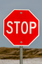

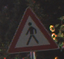

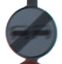

In [3]:
from PIL import Image
import numpy as np
from os import listdir
from os.path import isfile, join
from IPython.display import display

imgList = [f for f in listdir("/home/xilinx/jupyter_notebooks/bnn/road_signs/") if isfile(join("/home/xilinx/jupyter_notebooks/bnn/road_signs/", f))]

images = []
   
for imgFile in imgList:
	img = Image.open("/home/xilinx/jupyter_notebooks/bnn/road_signs/" + imgFile)
	images.append(img)    
	img.thumbnail((64, 64), Image.ANTIALIAS)
	display(img) 
  

# 4. Launching BNN in hardware
The images are passed in the PL and the inference is performed

In [4]:
results = classifier.classify_images(images)
print("Identified classes: {0}".format(results))
for index in results:
    print("Identified class name: {0}".format((classifier.class_name(index))))

Inference took 2732.00 microseconds, 910.67 usec per image
Classification rate: 1098.10 images per second
Identified classes: [14 27 41]
Identified class name: Stop
Identified class name: Pedestrians in road ahead
Identified class name: End of no-overtaking zone


# 5. Launching BNN in software
The inference on the same image is performed in sofware on the ARM core by passing the RUNTIME_SW parameter to the ImageClassifier

In [5]:
sw_class = bnn.CnvClassifier("road-signs", bnn.RUNTIME_SW)

results = sw_class.classify_images(images)
print("Identified classes: {0}".format(results))
for index in results:
    print("Identified class name: {0}".format((classifier.class_name(index))))

Inference took 2453237.06 microseconds, 817745.69 usec per image
Classification rate: 1.22 images per second
Identified classes: [14 27 41]
Identified class name: Stop
Identified class name: Pedestrians in road ahead
Identified class name: End of no-overtaking zone


# Classifying multiple images

This example is going to create a string of images from a single input image, tiling the image to try and locate an object. This image is a somewhat empty looking motorway and the aim is to find the cars.

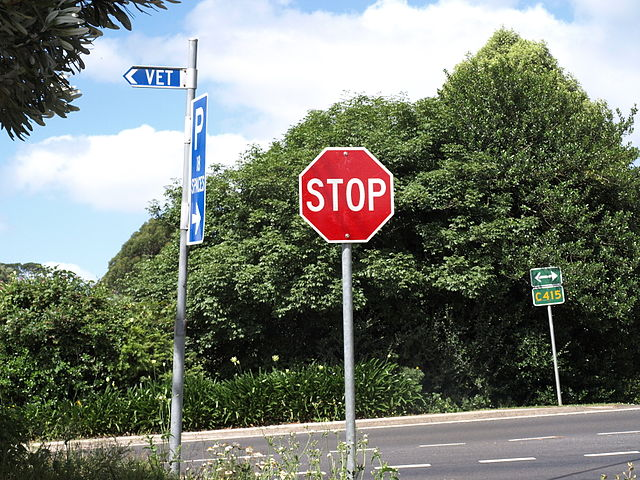

In [6]:
from PIL import Image
image_file = "/home/xilinx/jupyter_notebooks/bnn/street_with_stop.JPG"
im = Image.open(image_file)
im

Here we launch the classification on all the tiles from the source image, and all image in which the BNN identified a STOP signal is shown

In [7]:
images = []
bounds = []
for s in [64,96]:
    stride = s // 4
    x_tiles = im.width // stride
    y_tiles = im.height // stride
    
    for j in range(y_tiles):
        for i in range(x_tiles):
            bound = (stride * i, stride * j, stride * i + s, stride * j + s)
            if bound[2] <= im.width and bound[3] < im.height:
                c = im.crop(bound)
                images.append(c)
                bounds.append(bound)

print(len(images))

1330


Inference took 437651.01 microseconds, 329.06 usec per image
Classification rate: 3038.95 images per second


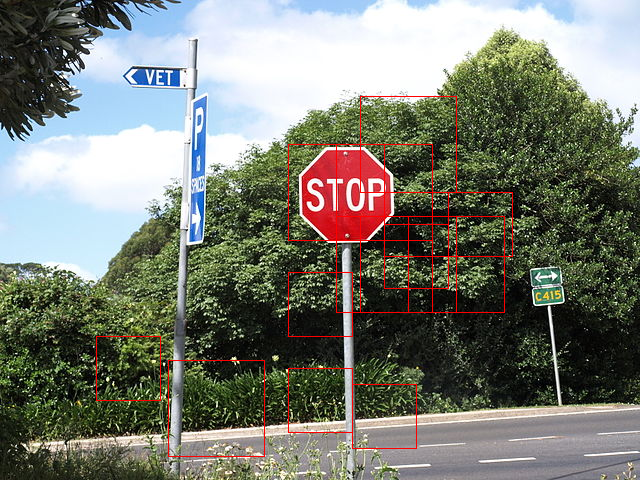

In [8]:
results = classifier.classify_images(images)
stop = results == 14
indicies = []
indicies = stop.nonzero()[0]
from PIL import ImageDraw
im2 = Image.open(image_file)
draw2 = ImageDraw.Draw(im2)
for i in indicies:
    draw2.rectangle(bounds[i], outline='red')

im2

Now the classification is post-analyzed in order to pick only the tiles in which the STOP signal is identified with a score higher than a certain threshold, in order to remove false positive

Inference took 437698.02 microseconds, 329.10 usec per image
Classification rate: 3038.62 images per second


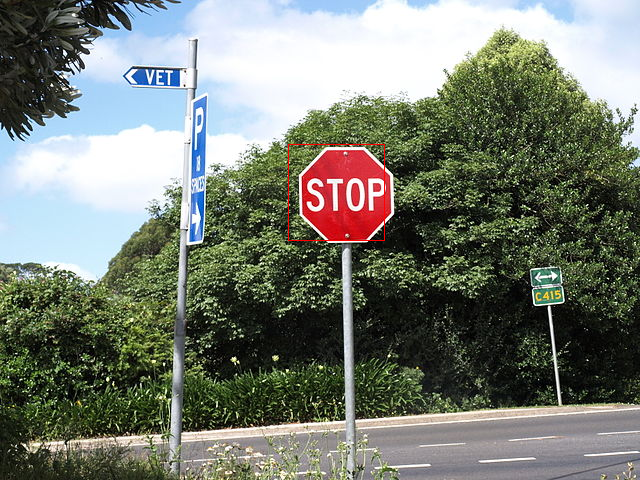

In [9]:
result = classifier.classify_images_details(images)
result=result.reshape(len(images),43)
from PIL import ImageDraw

draw = ImageDraw.Draw(im)
i=0
for image in images:
    if result[i][14] > 370:
        draw.rectangle(bounds[i], outline='red')
    i=i+1    
    
im

## Reseting the device

In [10]:
from pynq import Xlnk

xlnk = Xlnk();
xlnk.xlnk_reset()